This notebook is a first exploration to the distance-based network metrics used for measuring system accessibility in the BSS and the inter-station proximity.

As it is an initial version of the research the naming is changed. System accessibility is named "coverage" in here, and inter-station proximity is named "internal".

---
Author: Jordi Grau Escolano


# 1. Load data

In [1]:
import itertools
import os
import sys
import random
import json

import matplotlib.pyplot as plt  # type: ignore
import networkx as nx  # type: ignore
import numpy as np  # type: ignore
import osmnx as ox  # type: ignore
from sklearn.cluster import KMeans  # type: ignore

notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '../'))
sys.path.append(project_root)

from paths import *

location = 'Barcelona, Barcelona, Catalunya, España'
bcn_boundary = ox.geocode_to_gdf(location)
G = ox.graph_from_place(location, network_type='bike', simplify=True, retain_all=False)
G = ox.project_graph(G)
G_und = G.to_undirected()

# Create a position dictionary for edge weight calculation.    
pos = {node: (data['x'], data['y']) for node, data in G_und.nodes(data=True)}

# Assign distances as edge weights.
for u, v, data in G_und.edges(data=True):
    data['weight'] = data['length']

print("Number of edges in the graph: ", len(G.edges()))
print("Number of edges in the undirected graph: ", len(G_und.edges()))

Number of edges in the graph:  38995
Number of edges in the undirected graph:  28376


# 2. Define functions

In [ ]:
# Visualization helper functions
def mark_graph(G, S):
    # Mark each node with a 'selected' attribute.
    for node in G.nodes():
        G.nodes[node]['selected'] = node in S
    
    return G

def randomly_mark_graph(G, N):
    """
    Marks N random nodes in the graph with an attribute 'selected' set to True. Otherwise, False.
    
    Parameters:
        G (networkx.Graph or networkx.MultiGraph): The input graph.
        N (int): The number of nodes to mark.
    
    Returns:
        networkx.Graph or networkx.MultiGraph: The graph with updated node attributes.
    """
    if N > len(G):
        raise ValueError("N cannot be greater than the number of nodes in the graph.")
    
    # Randomly sample N nodes to mark as selected.
    selected_nodes = set(random.sample(list(G.nodes()), N))
    print(selected_nodes)
    
    # Mark each node with a 'selected' attribute.   
    return mark_graph(G, selected_nodes), selected_nodes
    
def plot_graph_with_highlighted_nodes(G, bcn_boundary, title_string, 
                                      selected_nodes=False, 
                                      ax=None,
                                      selected_node_color='red',
                                      default_node_color='blue',
                                      selected_node_size=8,
                                      default_node_size=0.1,
                                      edge_color='gray',
                                      edge_linewidth=0.1):
    """
    Plots the full graph G, but styles nodes differently depending on whether they are marked as 'selected'.
    
    Parameters:
        G (networkx.Graph or networkx.MultiGraph): The graph to plot.
        bcn_boundary (GeoDataFrame): The boundary polygon of Barcelona to plot.
        title_string (str): Title to display on the plot.
        selected_nodes (list, optional): List of nodes to highlight. If False, uses nodes marked as 'selected' in graph attributes.
        ax (matplotlib.axes.Axes, optional): Axes on which to plot the graph.
        selected_node_color (str): Color for selected/highlighted nodes.
        default_node_color (str): Color for non-selected nodes.
        selected_node_size (float): Size for selected/highlighted nodes.
        default_node_size (float): Size for non-selected nodes.
        edge_color (str): Color for edges.
        edge_linewidth (float): Line width for edges.
        
    Returns:
        matplotlib.axes.Axes: The axes containing the plot.
    """
    
    # Reproject the boundary to match the graph's CRS if available
    if 'crs' in G.graph:
        bcn_boundary = bcn_boundary.to_crs(G.graph['crs'])
    
    # Prepare lists of nodes based on their selection status.
    if not selected_nodes:
        selected_nodes = [node for node, data in G.nodes(data=True) if data.get('selected')]
    non_selected_nodes = [node for node, data in G.nodes(data=True) if not data.get('selected')]
    
    # Extract node positions (assuming they have 'x' and 'y' attributes)
    # (OSMnx graphs typically have these attributes.)
    pos = {node: (data.get('x'), data.get('y')) for node, data in G.nodes(data=True)}

    bcn_boundary.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
    
    # Draw all edges
    # nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_color, width=edge_linewidth, arrows=False)
    
    # Draw non-selected nodes
    # nx.draw_networkx_nodes(G, pos, nodelist=non_selected_nodes,
    #                        node_color=default_node_color,
    #                        node_size=default_node_size, ax=ax)
    
    # Draw selected nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes,
                           node_color=selected_node_color,
                           node_size=selected_node_size, ax=ax)
    
    ax.set_title(title_string, fontsize=13)
    
    return ax

In [ ]:
def _precompute_shortest_paths(G, weight='weight'):
    """
    Precomputes shortest path distances between all pairs of nodes in the graph using Dijkstra's algorithm.
    If a cached version exists, loads it instead of recomputing.

    Parameters:
        G (networkx.Graph): The input graph.
        cache_file (str): Path to the JSON file where precomputed shortest paths are stored.
        weight (str): The edge attribute used as weight (default: 'weight').

    Returns:
        dict: A dictionary where shortest_paths[u][v] gives the shortest-path
              distance from node u to node v.
    """
    # Check if the cache file exists
    sp_file = f'../{PR_NODES}/shortest_paths.json'
    # if os.path.exists(sp_file):
    #     with open(sp_file, "r") as f:
    #         shortest_paths = json.load(f)
    #     # Convert dictionary keys back to integers (JSON stores them as strings)
    #     shortest_paths = {int(k): {int(kk): vv for kk, vv in v.items()} for k, v in shortest_paths.items()}
    #     return shortest_paths

    # Compute shortest paths if not cached
    print("Computing shortest paths...")
    shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G, weight=weight,))

    # # Save to file for future use
    # print("Saving shortest paths")
    # with open(sp_file, "w") as f:
    #     json.dump(shortest_paths, f)

    print(f"Shortest paths computed and saved to {sp_file}.")
    return shortest_paths

In [ ]:
# Helper functions for the heuristic-based normalization functions
def _get_min_positive_edge_weight(G, distance_constraint=False):
    """
    Returns the minimum positive edge weight found in G.
    If no positive edge weight is found, returns 0.
    """
    if not distance_constraint:
        w_min = float('inf')
        for _, _, data in G.edges(data=True):
            w = data.get('weight', 1)
            if w > 0 and w < w_min:
                w_min = w
        if w_min == float('inf'):
            w_min = 0
    if distance_constraint:
        w_min = distance_constraint
    return w_min


def _find_max_eccentricity_node(G, weight='weight'):
    """
    Finds the node with the maximum eccentricity in graph G.
    
    Args:
        G (networkx.Graph): The input graph.
        weight (str): The edge attribute to use as weight. Default is 'weight'.
    
    Returns:
        tuple: (max_ecc_node, max_ecc) where max_ecc_node is the node with the maximum eccentricity
               and max_ecc is the value of the maximum eccentricity.
    """
    # Load eccentricities from a json file if it exists
    eccentricities = {}
    excentricy_file = f'{PR_NODES}/eccentricities.json'
    if os.path.exists(excentricy_file):
        with open(excentricy_file, 'r') as f:
            eccentricities = json.load(f)
    else:
        # Compute all the shortest path distances
        shortest_paths = dict(nx.shortest_path_length(G, weight=weight))
        eccentricities = nx.eccentricity(G, sp=shortest_paths)
        with open(excentricy_file, 'w') as f:
            json.dump(eccentricities, f)

    max_ecc = max(eccentricities.values())
    max_ecc_node = max(eccentricities, key=eccentricities.get)
    
    return max_ecc_node, max_ecc


def _greedy_max_dispersion(G, N, weight='weight'):
    """
    Greedily selects N nodes in G to maximize the spread (dispersion) using a farthest-first 
    approach, but computes distances for all candidates at once via multi-source Dijkstra.
    It assumes that maximizing the minimum distance at each step is a reasonable proxy 
    for maximizing overall dispersion.
    
    At each iteration, it computes the shortest distance from every node in G to the current 
    set of selected nodes (S) using multi_source_dijkstra, then selects the candidate (not in S)
    with the maximum such distance.
    
    Returns:
        selected: List of N nodes selected.
    """
    # Start with node with max eccentricity (heuristic).
    initial_node, _ = _find_max_eccentricity_node(G, weight='weight')
    selected = [initial_node]
    candidate_set = set(G.nodes()) - {initial_node}
    
    while len(selected) < N:
        # Compute the minimum distance from every node to any node in 'selected'
        distances, _ = nx.multi_source_dijkstra(G, sources=selected, weight=weight)
        
        # For each candidate, get its distance from the selected set.
        # Then, pick the candidate with the maximum distance.
        best_candidate = None
        best_distance = -1
        for candidate in candidate_set:
            d = distances.get(candidate, float('inf'))  # In a connected graph, d should be finite.
            if d > best_distance:
                best_distance = d
                best_candidate = candidate
                
        if best_candidate is None:
            break  # Shouldn't happen in a connected graph.
            
        # Add the best candidate to the selected set and remove it from the candidates.
        selected.append(best_candidate)
        candidate_set.remove(best_candidate)
    
    return selected


In [ ]:
# Heuristic-based normalization functions
def min_internal_bound(G, N, distance_constraint=False):
    """
    Calculate the theoretical minimum bound for the internal metric, which is the sum of 
    pairwise shortest path distances between selected nodes (stations) in a graph.

    This function provides an estimate for the minimum possible value of the internal metric 
    by assuming all shortest paths are equal to the shortest edge in the graph.

    Parameters:
        G (networkx.Graph): An undirected graph where nodes represent locations and edges 
                            have weights representing distances.
        N (int): The number of nodes (stations) to select.
        distance_constraint (bool): If True, the minimum bound is set to the distance constraint. 
                                    Defaults to False.

    Returns:
        float: The theoretical minimum value for the internal metric, assuming all pairwise 
               distances are equal to the shortest edge in the graph.
    """
    # Calculate the minimum edge weight in the graph
    w_min = _get_min_positive_edge_weight(G, distance_constraint=distance_constraint)
    
    # Calculate the theoretical minimum internal metric
    min_int_bound = (N * (N - 1) / 2) * w_min

    return min_int_bound


def max_internal_metric(G, N, weight='weight'):
    """
    Approximates the maximum internal metric for N stations using greedy dispersion.
    
    Uses a greedy dispersion algorithm to select N nodes that approximately maximize
    the sum of pairwise distances between them.
    
    Args:
        G: A NetworkX graph.
        N: Number of stations to select.
        weight: Edge attribute to use as weight. Defaults to 'weight'.
    
    Returns:
        tuple:
            max_int_metric (float): Approximated maximum internal metric value.
    """
    # Realistic max heuristic
    selected = _greedy_max_dispersion(G, N, weight=weight)
    print(selected)
    max_int_metric = internal_metric(G, selected, weight=weight)

    return max_int_metric


def min_coverage_bound_kmeans(G, k, weight='weight'):
    """
    Uses k-means clustering on the node positions of graph G to select k representative nodes,
    then computes the coverage metric for these nodes. The coverage metric is defined as:
      sum_{v in V} min_{s in S} d(v, s)
    where S is the set of selected nodes.
    
    Parameters:
        G      : A NetworkX graph with node attributes 'x' and 'y' (projected coordinates).
        k      : The number of clusters (i.e. the number of nodes to select).
        weight : The edge attribute to use as weight (default: 'weight').
        
    Returns:
        best_bound    : The coverage metric (a float). Lower values indicate better coverage.
        selected_nodes: A list of the k selected nodes.
    """
    # Get positions and node list.
    nodes = list(G.nodes())
    pos = []
    for node in nodes:
        node_data = G.nodes[node]
        if 'x' in node_data and 'y' in node_data:
            pos.append([node_data['x'], node_data['y']])
        else:
            raise ValueError("Graph nodes must have 'x' and 'y' attributes for k-means clustering.")
    pos = np.array(pos)
    
    # Run k-means clustering.
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pos)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    # For each cluster, select the node closest to the centroid.
    selected_nodes = []
    for cluster in range(k):
        indices = np.where(labels == cluster)[0]
        cluster_nodes = [nodes[i] for i in indices]
        cluster_positions = pos[indices]
        centroid = centroids[cluster]
        # Compute Euclidean distances from each node in the cluster to the centroid.
        dists = np.linalg.norm(cluster_positions - centroid, axis=1)
        min_idx = np.argmin(dists)
        selected_node = cluster_nodes[min_idx]
        selected_nodes.append(selected_node)
    
    # Compute the coverage metric: for each node in G, compute the distance to its nearest selected node.
    distances_multi, _ = nx.multi_source_dijkstra(G, sources=selected_nodes, weight=weight)
    best_bound = sum(distances_multi.get(node, float('inf')) for node in G.nodes())
    
    return best_bound, selected_nodes


def max_coverage_bound(G, num_neighbors, weight='weight'):
    """
    Given a node (farthest_node) with maximum eccentricity in the graph G,
    this function finds its num_neighbors closest nodes (including farthest_node)
    and computes the sum of their farness values. Farness is defined as the sum 
    of shortest-path distances from a node to all other nodes in G.
    
    This sum can be used as a worst-case coverage normalization bound.
    
    Parameters:
        G             : A NetworkX graph.
        num_neighbors : The number of closest nodes (including max_ecc_node) to consider.
        weight        : The edge attribute used as weight (default: 'weight').
    
    Returns:
        worst_bound   : A float representing the sum of the farness values of the selected nodes.
        selected_nodes: A list of the selected nodes.
    """
    max_ecc_node, _ = max_ecc_node(G, weight='weight')

    # Compute shortest path distances from max_ecc_node
    distances = nx.single_source_dijkstra_path_length(G, max_ecc_node, weight=weight)
    
    # Sort nodes by increasing distance from max_ecc_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    
    # Select the closest num_neighbors nodes (including max_ecc_node)
    selected_nodes = [node for node, d in sorted_nodes[:num_neighbors]]
    print(selected_nodes)
    
    # For each selected node, compute its farness (sum of shortest-path distances to all nodes)
    distances, _ = nx.multi_source_dijkstra(G, sources=selected_nodes, weight='weight')
    total = sum(distances.get(node, float('inf')) for node in G.nodes())
        
    return total, selected_nodes


def normalize_values(value, min_val, max_val):
    """
    Normalize a value to the [0, 1] range given min and max.
    """
    if max_val - min_val == 0:
        return 0
    return (value - min_val) / (max_val - min_val)

In [ ]:
# Coverage metric (system accessibility) and internal metric (inter-station proximity)
def internal_metric(G, S, weight):
    """
    Computes the internal metric for a set of stations S in graph G. Defined
    as the sum of pairwise shortest-path distances among the stations.

    Args:
        G: NetworkX graph representing the network.
        S: Set or list of nodes selected as stations.

    Returns:
        float: Sum of pairwise shortest-path distances between stations.
    """
    total = 0
    for u, v in itertools.combinations(S, 2):
        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
        except nx.NetworkXNoPath:
            d = float('inf')
        total += d
    return total

def coverage_metric(G, S, weight):
    """
    Computes the coverage metric for a set of stations S in graph G. The coverage
    metric measures how well the stations cover the entire network by summing
    the shortest-path distances from each node to its nearest station. A lower value 
    indicates better coverage since nodes are closer to stations.

    Args:
        G: NetworkX graph representing the network.
        S: Set or list of nodes selected as stations.

    Returns:
        float: The coverage metric value. Returns infinity if any node is unreachable.
    """
    distances, _ = nx.multi_source_dijkstra(G, sources=S, weight=weight)
    total = sum(distances.get(node, float('inf')) for node in G.nodes())
    return total

def evaluate_normalize_and_invert_stations_set(G, S, alpha, cov_bounds, int_bounds):
    """
    Evaluates station placement quality by combining coverage and internal distance metrics.
    
    This function takes raw coverage and internal metrics for a set of stations, 
    normalizes them to a [0,1] range by the provided bounds, and then inverts them
    (1 - normalized_value) so that higher values indicate better performance. 
    Then, a weighted composite score based on the alpha parameter is computed.
    
    The coverage metric measures how well stations cover the network by summing shortest-path
    distances from each node to its nearest station. The internal metric sums pairwise distances
    between stations to measure their spread.
    
    Args:
        G (networkx.Graph): NetworkX graph representing the network.
        S (set or list): Nodes selected as stations.
        alpha (float): Trade-off parameter between 0 and 1. Higher values prioritize 
            coverage (alpha=1 considers only coverage), while lower values prioritize
            internal proximity (alpha=0 considers only internal metric).
        cov_bounds (tuple): (min, max) bounds for normalizing the coverage metric.
        int_bounds (tuple): (min, max) bounds for normalizing the internal metric.
    
    Returns:
        dict: Dictionary containing evaluation metrics:
            raw_coverage (str): Original coverage metric value, formatted with commas
            raw_internal (str): Original internal metric value, formatted with commas  
            normalized_coverage (str): Coverage metric normalized to [0,1]
            normalized_internal (str): Internal metric normalized to [0,1]
            inverted_coverage (str): Inverted normalized coverage (higher is better)
            inverted_internal (str): Inverted normalized internal (higher is better)
            composite_score (str): Weighted combination of inverted metrics based on alpha
    """
    # Compute the raw metrics (lower is better)
    raw_cov = coverage_metric(G, S, weight='weight')
    raw_int = internal_metric(G, S, weight='weight')
    
    # Normalize the inverted metrics to [0,1]
    norm_cov = normalize_values(raw_cov, cov_bounds[0], cov_bounds[1])
    norm_int = normalize_values(raw_int, int_bounds[0], int_bounds[1])

    inverted_int = 1 - norm_int
    inverted_cov = 1 - norm_cov
    
    # Composite score: alpha weights coverage, (1-alpha) weights internal proximity
    composite_score = alpha * inverted_cov + (1 - alpha) * inverted_int
    
    return {
        'density': f'Dis -> raw: {raw_int:,.0f} // norm: {norm_int:,.2f} // inv: {inverted_int:,.2f}' 
        ,'coverage': f'Acc -> raw: {raw_cov:,.0f} // norm: {norm_cov:,.2f} // inv: {inverted_cov:,.2f}' 
        ,'composite_score': f"{composite_score:,.2f}"
    }


# 3. Execution

In [ ]:
# 40 min
_precompute_shortest_paths(G_und, weight='weight')

In [ ]:
# Find the node with the maximum eccentricity
eccentricities = nx.eccentricity(G_und)
max_ecc_node = max(eccentricities, key=eccentricities.get)
print(max_ecc_node, eccentricities[max_ecc_node])
# 11 min

21639547 199


In [12]:
S_kmeans =        [8323472517, 576936642,   841867127,  11301266444, 30237706,   2976987341]
S_cov_max =       [21639547,   21639552,    3518665733, 528804972,   3518647618, 11458328543]
S_raco =          [1817801169, 1374275251,  1817801114, 1374275210,  1374275059, 1374275645]
S_comp_dalt =     [412453127,  1233754575,  1933546298, 2706253150,  1225051359, 8214961148]
S_comp_dat_mod0 = [412453127,  1233754575,  1933546298, 2706253150,  1225051359, 7664112545]
S_centr =         [30247434,   301572963,   8941504710, 8266692790,  8266692791, 9056235074]
S_centr_mod0 =    [2120743618, 301572963,   8941504710, 8266692790,  8266692791, 9056235074]
S_centr_mod1 =    [2120743618, 11283221152, 8941504710, 8266692790,  8266692791, 9056235074]
S_centr_mod2 =    [2120743618, 11283221152, 3309358381, 8266692790,  8266692791, 9056235074]
S_centr_mod3 =    [2120743618, 11283221152, 3309358381, 4554375438,  8266692791, 9056235074]
S_centr_mod4 =    [2120743618, 11283221152, 3309358381, 4554375438,  4992785943, 9056235074]
S_int_max =       [21639547,   4419191954,  1817801169, 2239779154,  9879132080, 6081551398]

# S_list = [S_kmeans, S_cov_max, S_raco, S_comp_dalt, S_comp_dat_mod0, S_centr, 
#     S_centr_mod0, S_centr_mod1, S_centr_mod2, S_centr_mod3, S_centr_mod4, S_int_max]

S_list = [
    S_centr, S_int_max,
    S_kmeans, S_cov_max,

    S_comp_dalt, S_raco, S_comp_dat_mod0, S_centr_mod0,
    S_centr_mod0, S_centr_mod1, S_centr_mod2, S_centr_mod3,
    # S_centr_mod4
    ]

# S_strings = ['kmeans', 'cov_max', 'raco', 'compacte_dalt', 'comp_dat_mod0', 
#              'centrality', 'centr_mod0', 'centr_mod1', 'centr_mod2', 'centr_mod3', 
#              'centr_mod4', 'molt_ample']

S_strings = [
    'D (centrality)', 'Dmax (periph. nodes)',
    'Amin (k-means)', 'Amax (neighbor max ecc node)',
    'Random1', 'Random2', 'Random3', 'Random4',
    'Random5', 'Random6', 'Random7', 'Random8'
    # 'kmeans', 'cov_max', 'raco', 'compacte_dalt', 'comp_dat_mod0', 
    #          'centrality', 'centr_mod0', 'centr_mod1', 'centr_mod2', 'centr_mod3', 
    #          'centr_mod4', 'molt_ample'
    ]

S_dict = {}
for string, nodes_list in zip(S_strings, S_list):
    S_dict[string] = nodes_list

In [ ]:
internal_alpha = 0.5
print(f"Alpha: {internal_alpha:.2f}")

# Compute internal bounds
len_stations = len(S_list[0])
min_int_bound = min_internal_bound(G_und, len_stations, distance_constraint=False)
max_int_bound = max_internal_metric(G_und, len_stations, weight='weight')
int_bounds = (round(min_int_bound), round(max_int_bound))
print(f"Internal bounds: ({int_bounds[0]:,}, {int_bounds[1]:,})")   

# # Compute coverage bounds
# max_cov_bound, _ = max_coverage_bound(G_und, len_stations)
# min_cov_bound, _ = min_coverage_bound_kmeans(G_und, len_stations)
# cov_bounds = (round(min_cov_bound), round(max_cov_bound))
# print(f"Coverage bounds: ({cov_bounds[0]:,}, {cov_bounds[1]:,})")

# # Plot stations and evalutaion metrics
# fig, axes = plt.subplots(3,4, figsize=(20,15))
# axes = axes.flatten()

# # For each station set in S_list evaluate coverage and internal proximity
# for idx, (S_string, nodes_list) in enumerate(S_dict.items()):
    
#     # Mark the selected nodes in a copy of the graph.
#     if idx <=4:
#         marked_graph = mark_graph(G_und, nodes_list)
#     else:
#         marked_graph, nodes_list = randomly_mark_graph(G_und, N=len(nodes_list))
    
#     # Evaluate the station set using the inverted and normalized metrics.
#     score_info = evaluate_normalize_and_invert_stations_set(G_und, nodes_list, internal_alpha, cov_bounds, int_bounds)
#     title_string = f"{S_string}\n"
#     for key, value in score_info.items():
#         if key in ['density', 'coverage', 'composite']:
#             title_string += f"{value}\n"

#     title_string = title_string[:-1]    
#     plot_graph_with_highlighted_nodes(marked_graph, bcn_boundary, title_string, ax=axes[idx])

# plt.tight_layout()
# plt.savefig(f'../{VISUALIZATIONS}/graph_metric_tests/graph_coverage.png')
# plt.show()

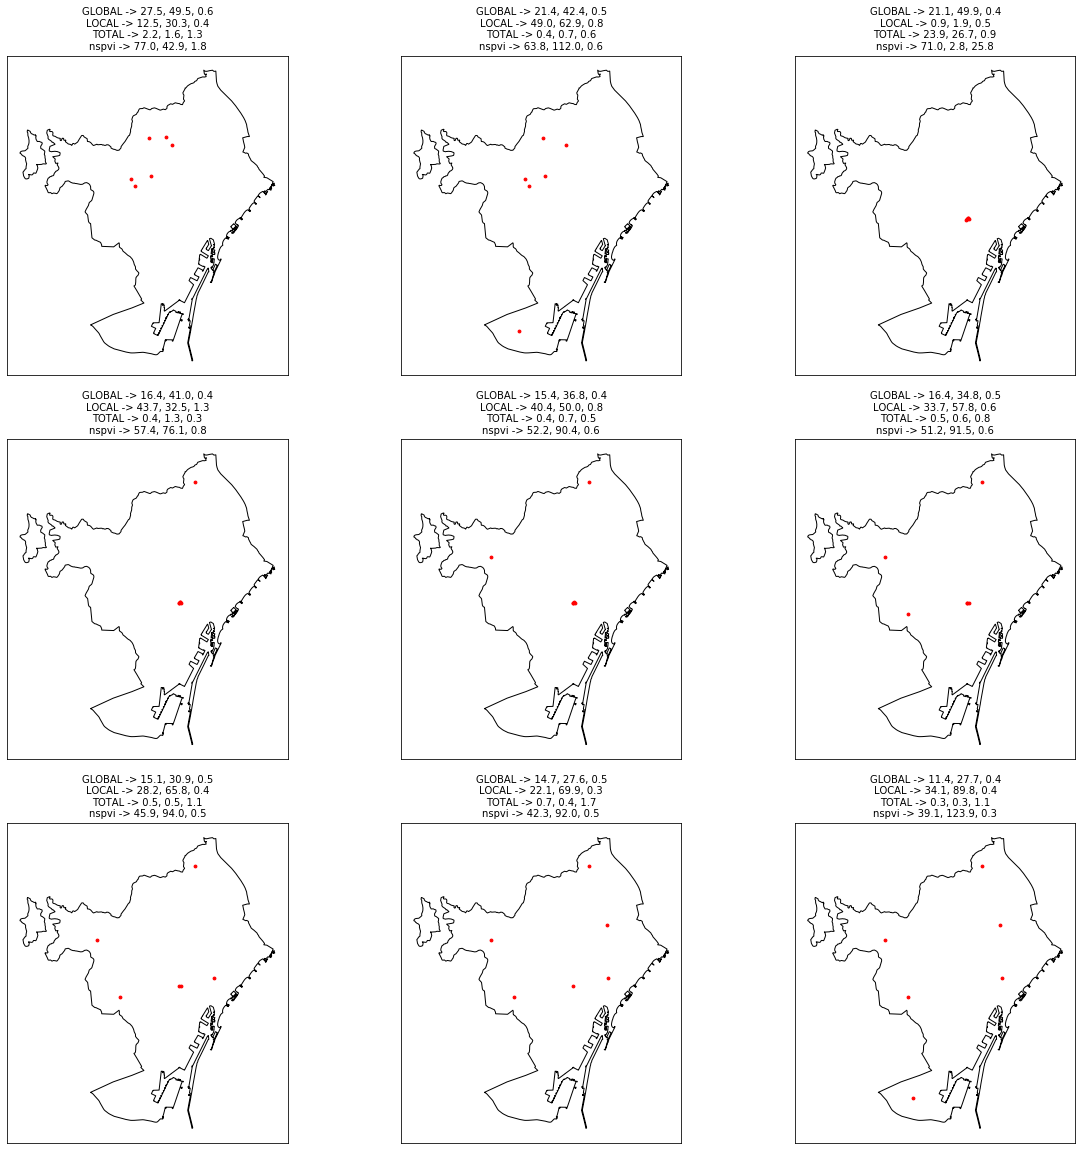

In [ ]:
S_dict = {}
for string, nodes_list in zip(S_strings, S_list):
    S_dict[string] = nodes_list

fig, axes = plt.subplots(3,3, figsize=(20,20))
axes = axes.flatten()

for idx, (S_string, nodes_list) in enumerate(S_dict.items()):

    marked_graph = mark_graph(G_und, nodes_list)

    # Compute global shortest paths stats
    sp = nx.multi_source_dijkstra_path_length(G, nodes_list)
    glb_sp = np.array(list(lengths.values()))
    glb_avg_sp = np.mean(glb_sp)
    glb_std_sp = np.std(glb_sp)
    glb_ratio = glb_std_sp / glb_avg_sp

    # Compute local shortest paths stats: pairwise distances among the selected nodes.
    local_sp = []
    for i, u in enumerate(nodes_list):
        lengths = nx.single_source_dijkstra_path_length(G_und, u)
        for j, v in enumerate(nodes_list):
            if j > i and v in lengths:  # count each pair only once
                local_sp.append(lengths[v])
    local_avg_sp = np.mean(local_sp)
    local_std_sp = np.std(local_sp)
    local_ratio = local_std_sp / local_avg_sp

    nspvi_g = glb_std_sp + glb_avg_sp
    nspvi_l = local_std_sp + local_avg_sp

    title_string = f"GLOBAL -> {glb_std_sp:.1f}, {glb_avg_sp:.1f}, {glb_ratio:.1f}\n" \
        f"LOCAL -> {local_std_sp:.1f}, {local_avg_sp:.1f}, {local_ratio:.1f}\n" \
        f"TOTAL -> {(glb_std_sp / local_std_sp):.1f}, {(glb_avg_sp / local_avg_sp):.1f}, {(glb_ratio / local_ratio):.1f}\n" \
        f"nspvi -> {(nspvi_g):.1f}, {(nspvi_l):.1f}, {(nspvi_g / nspvi_l):.1f}"

    plot_graph_with_highlighted_nodes(marked_graph, bcn_boundary, title_string, ax=axes[idx])

plt.savefig('A.png', dpi=300, bbox_inches='tight')
plt.savefig('A.pdf', bbox_inches='tight')

plt.show()